hypothesis: inducements are more likley to be granted *before* EPS over-performance or *after* EPS under-performance

Data limitations: resolution on inducements are poor, only timestamped on Mondays. Inducements surely happen on other days, and at specific times, but it appears they are rounded to the nearest Monday. This makes it unclear if inducements are granted before or after any particular date. ~33% of valid inducements occur within one week of outocme

method: basic statistical tests to capture direct effect, more complex models to capture conditional effect

result: there is no evidence in the data in support of the hypothesis 

#### Setup

In [150]:
### Data loading and cleaning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
import datetime
import warnings
import pickle
import math
import yfinance as yf
import os
from itertools import cycle
import seaborn as sns
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.naive_bayes as nb
import sklearn.svm as svm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None

# load prices as numeric dataframe
prices = pd.read_excel("price.xlsx", index_col=0).T.sort_index()
prices = prices.apply(pd.to_numeric, errors="coerce")
prices = prices.sort_index(axis=1)
prices = prices[prices.columns[prices.notna().any()]]  # drop cols with only nan

# load inducements
inducements = pd.read_excel("inducement.xlsx", index_col=0)
print(inducements.index.shape)


# drop tickers without price data. I just assume this lines up with public companies or else prices wouldnt be empty
inducements = inducements.loc[prices.columns]

# record information in case its useful and reformat
background = inducements[["Company", "MCap", "Sector", "Total"]]
background["index"] = np.arange(background.shape[0])
inducements = inducements.drop(
    columns=["Company", "MCap", "Sector", "Total"]
).T.sort_index()

# fix irregularities with index
prices.index = prices.index.snap("W-MON")

# fix irregularities with index
prices.index = prices.index.snap("W-MON")
inducements.index = prices.index.snap("W-MON")

assert inducements.index.equals(prices.index)

start_date = prices.index.min()
end_date = datetime.datetime.today()
complete_weekly_index = pd.date_range(start=start_date, end=end_date, freq="W-MON")

prices = prices.reindex(complete_weekly_index)
inducements = inducements.reindex(complete_weekly_index).fillna(0.0)
tickers = inducements.columns.tolist()
stacked_inducements = inducements.stack()
stacked_inducements = stacked_inducements[
    stacked_inducements != 0
]  # don't care about when inducements don't happen

assert prices.shape == inducements.shape
assert prices.index.equals(inducements.index)
assert prices.columns.equals(inducements.columns)

## Below this point, code relates to the unused prices data
# # linear interpolation on prices
# prices_int = prices.interpolate(limit_area='inside')

# # smoother on prices
# prices_int = prices_int.apply(lambda x: gaussian_filter1d(x, 1.8))
# # prices_int = prices_int.rolling(window=2, min_periods=1).mean()

# # detrend smoothed prices
# def detrend(series):
#     x = np.arange(len(series)) # time
#     X = sm.add_constant(x) # constant
#     model = sm.OLS(series, X).fit()
#     trend = model.predict(X)
#     detrended = series - trend
#     return detrended
# prices_det = prices_int.apply(detrend)

# # difference detrended prices
# prices_diff1 = prices_det - prices_det.shift(1)

# # evaluate mean ACF across tickers to see if we're done processing
# def mean_acf(dataframe, nlags=20):
#     acf_values = []

#     for column in dataframe.columns:
#         if dataframe[column].notna().any():
#             acf_col = acf(dataframe[column], nlags=nlags, fft=True, missing="drop")
#             acf_values.append(acf_col)

#     acf_df = pd.DataFrame(acf_values)
#     mean_acf_values = acf_df.mean(axis=0)
#     return mean_acf_values

# def mean_pacf(dataframe, nlags=20):
#     acf_values = []

#     for column in dataframe.columns:
#         if dataframe[column].notna().any():
#             acf_col = pacf(dataframe[column], nlags=nlags)
#             acf_values.append(acf_col)

#     acf_df = pd.DataFrame(acf_values)
#     mean_acf_values = acf_df.mean(axis=0)
#     return mean_acf_values

# mean_acf_values = mean_acf(prices_diff1)
# mean_pacf_values = mean_pacf(prices_diff1)

# # second derivatives
# dd_prices = prices_diff1.apply(lambda x: np.gradient(np.gradient(x)))


(402,)


In [151]:
proxies = cycle([...]) # list proxies here

def fetch_earnings_data(ticker, proxies):
    print(ticker)
    stock = yf.Ticker(ticker)
    curr_proxy = next(proxies)
    return stock.get_earnings_dates(
        limit=50, proxy={"https": curr_proxy, "http": curr_proxy}
    )

def get_earnings_data(tickers, proxies):
    all_data = {}
    for ticker in tickers:
        df = fetch_earnings_data(ticker, proxies)
        if df is not None and not df.empty:
            all_data[ticker] = df
    return all_data

n_tickers = len(tickers)
n_splits = 20
len_split = math.floor(n_tickers / n_splits) + 1

# load data
for i in range(n_splits):
    filename = f"ern{i}.pkl"
    if os.path.exists(filename):  # check for file
        print(f"{filename} already exists.")
    else:  # else create it
        earnings_data = get_earnings_data(
            tickers[i * len_split : (i + 1) * len_split], proxies
        )
        with open(filename, "wb") as file:
            pickle.dump(earnings_data, file)
        print(f"{filename} created.")


ern0.pkl already exists.
ern1.pkl already exists.
ern2.pkl already exists.
ern3.pkl already exists.
ern4.pkl already exists.
ern5.pkl already exists.
ern6.pkl already exists.
ern7.pkl already exists.
ern8.pkl already exists.
ern9.pkl already exists.
ern10.pkl already exists.
ern11.pkl already exists.
ern12.pkl already exists.
ern13.pkl already exists.
ern14.pkl already exists.
ern15.pkl already exists.
ern16.pkl already exists.
ern17.pkl already exists.
ern18.pkl already exists.
ern19.pkl already exists.


In [152]:
# load earnings data
bigdict = {}
for i in range(n_splits):
    filename = f"ern{i}.pkl"
    with open(filename, "rb") as file:
        bigdict.update(pickle.load(file))

# reformat to one big dataframe
df_list = []
for key, df in bigdict.items():
    to_add = df.reset_index().rename(columns={"index": "Earnings Date"})
    to_add["Ticker"] = key
    df_list.append(to_add)
earnings_df = pd.concat(df_list, ignore_index=True)
earnings_df["Earnings Date"] = pd.to_datetime(
    earnings_df["Earnings Date"]
).dt.tz_convert(None)  # ensure format

# add beat
earnings_df["Beat"] = earnings_df["Surprise(%)"].apply(lambda x: 1 if x > 0 else 0)
# add change since last filing
earnings_df = earnings_df.sort_values(['Ticker', 'Earnings Date'])
earnings_df['Earnings Change'] = earnings_df.groupby('Ticker')['Reported EPS'].pct_change()

# filter out bad data
earnings_df = earnings_df[
    (earnings_df["Earnings Date"] >= start_date - pd.Timedelta(150, "D"))
    & (earnings_df["Earnings Date"] <= end_date)
]  # 150 days ensures we don't miss any earnings
earnings_df.dropna(subset=['EPS Estimate', 'Reported EPS'],inplace=True)
# nans is this column occur when EPS Estimate == Reported EPS, should take value 0
earnings_df['Surprise(%)'] = earnings_df['Surprise(%)'].fillna(0)


In [153]:
# function to fix mcap
def convert_to_number(s):
    if s.endswith("B"):
        return float(s[:-1]) * 1e9
    elif s.endswith("M"):
        return float(s[:-1]) * 1e6
    elif s.endswith("K"):
        return float(s[:-1]) * 1e3
    else:
        return float(s)


# create big dataframe which incorporates inducements AND earnings
df = pd.DataFrame(
    columns=[
        "Ticker",
        "Earnings Date",
        "Inducement Date",
        "Timing",
        "Num Inducements",
        "Beat",
        "EPS Estimate",
        "Reported EPS",
        "Surprise(%)",
        "Earnings Change",
    ]
)
for tstamp, ticker in stacked_inducements.index:
    num_inducements = stacked_inducements[(tstamp, ticker)]
    relevant = earnings_df[earnings_df["Ticker"] == ticker].copy()
    relevant["Diff"] = tstamp - relevant["Earnings Date"]
    relevant["Absdiff"] = relevant["Diff"].abs()
    if not relevant.empty:
        closest_row = relevant.loc[relevant["Absdiff"].idxmin()]
        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    [
                        [
                            ticker,
                            closest_row["Earnings Date"],
                            tstamp,
                            closest_row["Diff"],
                            num_inducements,
                            closest_row["Beat"],
                            closest_row["EPS Estimate"],
                            closest_row["Reported EPS"],
                            closest_row["Surprise(%)"],
                            closest_row["Earnings Change"],
                        ]
                    ],
                    columns=df.columns,
                ),
            ],
            ignore_index=True,
        )

# include info from background df
df["Total"] = df["Ticker"].apply(lambda x: background["Total"][x])
df["Sector"] = df["Ticker"].apply(lambda x: background["Sector"][x])
df["MCap"] = df["Ticker"].apply(lambda x: background["MCap"][x])
df["MCap"] = np.log(df["MCap"].apply(convert_to_number))

# engineer some features
df["Close Call"] = df["Timing"].apply(lambda x: 1 if abs(x) < pd.Timedelta("7D") else 0)
df["Before"] = df["Timing"].apply(lambda x: 1 if x < pd.Timedelta("0D") else 0)
df["Beat"] = df["Beat"].astype(int)
df["Timing"] = df["Timing"] / np.timedelta64(1, "D")  # get timing as float
df["Quartile Surprise"] = pd.qcut(df["Surprise(%)"], 4, labels=[0, 1, 2, 3]).astype(int)
df["Earnings Increased"] = df["Earnings Change"].apply(lambda x: 1 if x > 0 else 0)

# create cumulative sum of inducements
df = df.sort_values(by=["Ticker", "Earnings Date"])
df["Cum Inducements"] = np.log(df.groupby("Ticker")["Num Inducements"].cumsum())

# subset out bad data
bad_pts = df[np.abs(df["Timing"]) > 70]
df = df[
    np.abs(df["Timing"]) < 70
]  # allows 140 days between 10-Qs, just beyond legal limit

# notes: MCap and Cum Inducements are log transformed

print(f"Within-one-week Inducements: {df['Close Call'].mean()*100:.2f}%")


Within-one-week Inducements: 32.88%


In [154]:
bad_pts.shape

(56, 18)

#### Exploratory

<Axes: >

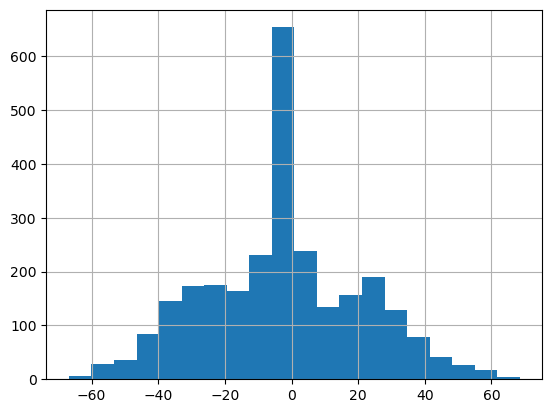

In [155]:
df['Timing'].hist(bins=20)

<Axes: >

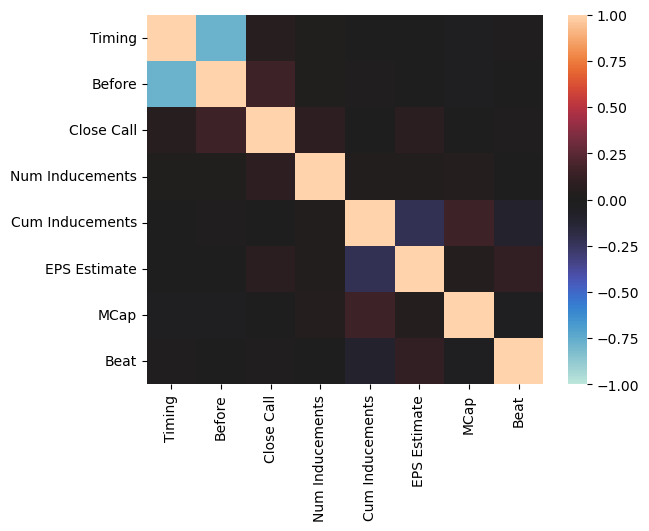

In [156]:
# normalize for uniform scale:
df[["Timing", "Num Inducements", "EPS Estimate", "Cum Inducements", "MCap"]] = (
        StandardScaler().fit_transform(df[["Timing", "Num Inducements", "EPS Estimate", "Cum Inducements", "MCap"]])
    )
sns.heatmap(df.select_dtypes(include=["number"])[["Timing", "Before", "Close Call", "Num Inducements", "Cum Inducements", "EPS Estimate","MCap", "Beat"]].corr(), vmin=-1, vmax=1, center=0)


In [157]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df["Beat"].values, df["Before"].values)


array([[513, 853],
       [502, 845]], dtype=int64)

In [158]:
from scipy.stats import ttest_ind, ks_2samp

before_grp = df[df["Before"] == 1]
after_grp = df[df["Before"] == 0]

print(ttest_ind(before_grp["Surprise(%)"], after_grp.query('index !=[1582, 1601]')["Surprise(%)"]))
print(ttest_ind(before_grp["Beat"], after_grp["Beat"]))
print(ttest_ind(before_grp["Quartile Surprise"], after_grp["Quartile Surprise"]))

print(ks_2samp(before_grp["Surprise(%)"], after_grp["Surprise(%)"]))
print(ks_2samp(before_grp["Beat"], after_grp["Beat"]))
print(ks_2samp(before_grp["Quartile Surprise"], after_grp["Quartile Surprise"]))



TtestResult(statistic=0.7558304200828494, pvalue=0.4498165905999414, df=2709.0)
TtestResult(statistic=0.15435024296153615, pvalue=0.8773450729679383, df=2711.0)
TtestResult(statistic=0.8013239411537406, pvalue=0.4230143598939451, df=2711.0)
KstestResult(statistic=0.027722559719635387, pvalue=0.6994897156456183, statistic_location=0.1962, statistic_sign=-1)
KstestResult(statistic=0.0030630066087602337, pvalue=1.0, statistic_location=0, statistic_sign=-1)
KstestResult(statistic=0.02230093938391733, pvalue=0.9009335780973511, statistic_location=2, statistic_sign=-1)


In [159]:
before_grp.describe()

,Earnings Date,Inducement Date,Timing,Num Inducements,Beat,EPS Estimate,Reported EPS,Surprise(%),Earnings Change,Total,MCap,Close Call,Before,Quartile Surprise,Earnings Increased,Cum Inducements
count,1698,1698,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1695.000000,1698.000000,1698.000000,1698.000000,1698.0,1698.000000,1698.000000,1698.000000
mean,2022-09-30 22:54:52.579505408,2022-09-13 19:55:45.583038976,-0.599982,0.014739,0.497644,0.005674,-0.543604,-0.060300,-0.001671,30.731449,-0.028334,0.385159,1.0,1.508245,0.435807,0.010637
min,2019-10-28 11:00:00,2019-09-09 00:00:00,-2.651030,-0.217479,0.000000,-6.316972,-11.000000,-17.095600,-41.000000,1.000000,-1.551691,0.000000,1.0,0.000000,0.000000,-1.860716
25%,2021-11-04 20:00:00,2021-10-25 00:00:00,-1.124368,-0.217479,0.000000,-0.373402,-0.920000,-0.178975,-0.270728,12.000000,-0.839363,0.000000,1.0,1.000000,0.000000,-0.678702
50%,2023-02-21 21:00:00,2023-01-12 12:00:00,-0.340406,-0.217479,0.000000,0.043306,-0.480000,0.000000,0.000000,22.000000,-0.177432,0.000000,1.0,1.000000,0.000000,0.102567
75%,2023-11-07 11:45:00,2023-10-23 00:00:00,-0.036105,-0.217479,1.000000,0.438082,-0.100000,0.170775,0.177496,46.000000,0.647743,1.000000,1.0,3.000000,1.000000,0.774839
max,2024-06-05 20:00:00,2024-06-03 00:00:00,0.089398,8.416958,1.000000,9.035424,11.160000,30.842800,90.000000,95.000000,4.307635,1.000000,1.0,3.000000,1.000000,2.013091
std,NaN,NaN,0.650704,0.883607,0.500142,0.914467,1.072072,1.980804,4.868692,24.825538,0.994361,0.486776,0.0,1.115695,0.496008,0.988330


(-5.0, 5.0)

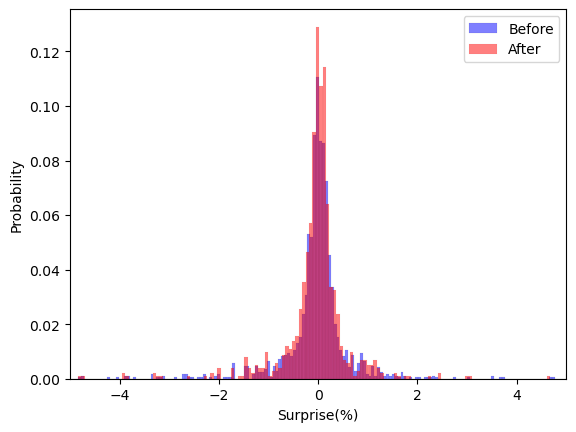

In [160]:
fig, axes = plt.subplots()
# sns.boxplot(x=df['Before'], y=df['Surprise(%)'])
sns.histplot(
    df[df["Before"] == 1]["Surprise(%)"],
    color="blue",
    label="Before",
    alpha=0.5,
    stat="probability",
    ax=axes,
)

# # Plot the second histogram for group 'B'
sns.histplot(
    df[df["Before"] == 0]["Surprise(%)"],
    color="red",
    label="After",
    alpha=0.5,
    stat="probability",
    ax=axes,
)
axes.legend()
axes.set_xlim(-5, 5)


#### Modeling Binary Outcome

In [24]:
def learn_model_params():
    suffs = ["base", "int", "nt", "nt_int"] # name different setups

    y_bin = df["Beat"].values  # define target

    # define train/test data
    X = df[
        [
            "Timing",
            "Num Inducements",
            "EPS Estimate",
            "Before",
            "Close Call",
            "Cum Inducements",
            "MCap",
        ]
    ]
    X[["Timing", "Num Inducements", "EPS Estimate", "Cum Inducements", "MCap"]] = (
        StandardScaler().fit_transform(X[["Timing", "Num Inducements", "EPS Estimate", "Cum Inducements", "MCap"]])
    )
    dt = train_test_split(X, y_bin, test_size=0.3, random_state=5, stratify=y_bin)

    degree2poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
    X_int = degree2poly.fit_transform(X)
    X_int = StandardScaler().fit_transform(X_int)
    int_dt = train_test_split(
        X_int, y_bin, test_size=0.3, random_state=5, stratify=y_bin
    )

    nt_dt = train_test_split(
        X[["Num Inducements", "EPS Estimate", "Cum Inducements", "MCap"]],
        y_bin,
        test_size=0.3,
        random_state=5,
        stratify=y_bin,
    )

    X_nt_int = degree2poly.fit_transform(
        X[["Num Inducements", "EPS Estimate", "Cum Inducements", "MCap"]]
    )
    X_nt_int = StandardScaler().fit_transform(X_nt_int)
    nt_int_dt = train_test_split(
        X_nt_int, y_bin, test_size=0.3, random_state=5, stratify=y_bin
    )

    dt_list = [dt, int_dt, nt_dt, nt_int_dt]

    # create dicts to store data
    results_dict = {}
    params_dict = {}
    models_dict = {}
    for suffix, data in zip(suffs, dt_list):
        results_df = pd.DataFrame(columns=["Train", "Test"])
        X_train, X_test, y_train, y_test = data

        ### model training
        print(f"{suffix}")

        # logistic regression
        param_grid = {
            "solver": ["liblinear"],
            "penalty": ["l1"],
            "fit_intercept": [True, False],
            "C": np.logspace(-4, 4, 25),
            "max_iter": [1000],
        }
        logreg = GridSearchCV(lm.LogisticRegression(), param_grid, cv=5, n_jobs=-1).fit(
            X_train, y_train
        )
        params_dict[f"logreg_{suffix}"] = logreg.best_params_
        results_df.loc[f"logreg_{suffix}"] = [
            logreg.score(X_train, y_train),
            logreg.score(X_test, y_test),
        ]
        models_dict[f"logreg_{suffix}"] = logreg
        print("Logisitic Regression:")
        print("training accuracy:", logreg.score(X_train, y_train))
        print("test accuracy:", logreg.score(X_test, y_test))
        print()
        
        # adaboost
        param_grid = {
            "n_estimators": [30, 50, 80, 150],
            "learning_rate": [0.5, 0.75, 1, 1.5],
        }
        adaboost = GridSearchCV(
            en.AdaBoostClassifier(), param_grid, cv=5, n_jobs=-1
        ).fit(X_train, y_train)
        params_dict[f"adaboost_{suffix}"] = adaboost.best_params_
        results_df.loc[f"adaboost_{suffix}"] = [
            adaboost.score(X_train, y_train),
            adaboost.score(X_test, y_test),
        ]
        models_dict[f"adaboost_{suffix}"] = adaboost
        print("Adaboost:")
        print("training accuracy:", adaboost.score(X_train, y_train))
        print("test accuracy:", adaboost.score(X_test, y_test))
        print()

        # random forest
        param_grid = {
            "max_depth": [3, 5, 10, 50],
            "max_features": [2, 3, 4, 5],
            "min_samples_leaf": [3, 4, 5],
            "min_samples_split": [8, 10, 12],
            "n_estimators": [70, 100, 200, 500],
        }
        rf = GridSearchCV(
            en.RandomForestClassifier(), param_grid=param_grid, cv=5, n_jobs=-1
        ).fit(X_train, y_train)
        params_dict[f"rf_{suffix}"] = rf.best_params_
        results_df.loc[f"rf_{suffix}"] = [
            rf.score(X_train, y_train),
            rf.score(X_test, y_test),
        ]
        models_dict[f"rf_{suffix}"] = rf
        print("Random Forest:")
        print("training accuracy:", rf.score(X_train, y_train))
        print("test accuracy:", rf.score(X_test, y_test))
        print()

        # gradient boost
        param_grid = {
            "max_depth": [3, 5, 10, 50],
            "max_features": [2, 3, 4, 5],
            "min_samples_leaf": [3, 4, 5],
            "min_samples_split": [8, 10, 12],
            "n_estimators": [70, 100, 200, 500],
            "subsample": [0.3, 0.5, 1],
        }
        gboost = GridSearchCV(
            en.GradientBoostingClassifier(), param_grid=param_grid, cv=5, n_jobs=-1
        ).fit(X_train, y_train)
        params_dict[f"gboost_{suffix}"] = gboost.best_params_
        results_df.loc[f"gboost_{suffix}"] = [
            gboost.score(X_train, y_train),
            gboost.score(X_test, y_test),
        ]
        models_dict[f"gboost_{suffix}"] = gboost
        print("Gradient Boost:")
        print("training accuracy:", gboost.score(X_train, y_train))
        print("test accuracy:", gboost.score(X_test, y_test))
        print()

        # support vector machines
        param_grid = {
            "C": np.logspace(-4, 4, 25),
            "kernel": ["rbf", "linear"],
        }
        svms = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=5, n_jobs=-1).fit(
            X_train, y_train
        )
        params_dict[f"svm_{suffix}"] = svms.best_params_
        results_df.loc[f"svm_{suffix}"] = [
            svms.score(X_train, y_train),
            svms.score(X_test, y_test),
        ]
        models_dict[f"svm_{suffix}"] = svms
        print("SVM:")
        print("training accuracy:", svms.score(X_train, y_train))
        print("test accuracy:", svms.score(X_test, y_test))

        results_dict[f"{suffix}"] = results_df
    return results_dict, params_dict, models_dict


In [25]:
if os.path.exists("best_params.pkl"):  # check for file w/ results
    with open("best_params.pkl", "rb") as file:
        params_dict = pickle.load(file)
    with open("best_models.pkl", "rb") as file:
        models_dict = pickle.load(file)
    with open("best_results.pkl", "rb") as file:
        results_dict = pickle.load(file)
else:  # else create it
    results_dict, params_dict, models_dict = learn_model_params()
    with open("best_params.pkl", "wb") as file:
        pickle.dump(params_dict, file)
    with open("best_models.pkl", "wb") as file:
        pickle.dump(models_dict, file)
    with open("best_results.pkl", "wb") as file:
        pickle.dump(results_dict, file)


base
Logisitic Regression:
training accuracy: 0.5490514905149051
test accuracy: 0.5492424242424242

Adaboost:
training accuracy: 0.7013550135501355
test accuracy: 0.6161616161616161

Random Forest:
training accuracy: 0.9371273712737127
test accuracy: 0.7007575757575758

Gradient Boost:
training accuracy: 1.0
test accuracy: 0.7424242424242424

SVM:
training accuracy: 0.5940379403794038
test accuracy: 0.5631313131313131
int
Logisitic Regression:
training accuracy: 0.5907859078590786
test accuracy: 0.5555555555555556

Adaboost:
training accuracy: 0.737669376693767
test accuracy: 0.6022727272727273

Random Forest:
training accuracy: 0.9663956639566396
test accuracy: 0.6679292929292929

Gradient Boost:
training accuracy: 1.0
test accuracy: 0.6957070707070707

SVM:
training accuracy: 0.791869918699187
test accuracy: 0.5378787878787878
nt
Logisitic Regression:
training accuracy: 0.5528455284552846
test accuracy: 0.5542929292929293

Adaboost:
training accuracy: 0.6265582655826558
test accuracy

In [135]:
multi_index_df = pd.concat(results_dict, axis=1)

In [134]:
for i in results_dict.keys():
    results_dict[i].index = ['Logistic Regression', 'AdaBoost', 'Random Forest', 'Gradient Boost', 'Support Vector Machines']

In [140]:
print(multi_index_df.to_latex(float_format='%.2f'))

\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{2}{r}{base} & \multicolumn{2}{r}{int} & \multicolumn{2}{r}{nt} & \multicolumn{2}{r}{nt_int} \\
 & Train & Test & Train & Test & Train & Test & Train & Test \\
\midrule
Logistic Regression & 0.55 & 0.55 & 0.59 & 0.56 & 0.55 & 0.55 & 0.58 & 0.58 \\
AdaBoost & 0.70 & 0.62 & 0.74 & 0.60 & 0.63 & 0.58 & 0.76 & 0.66 \\
Random Forest & 0.94 & 0.70 & 0.97 & 0.67 & 0.94 & 0.77 & 0.95 & 0.75 \\
Gradient Boost & 1.00 & 0.74 & 1.00 & 0.70 & 1.00 & 0.80 & 1.00 & 0.80 \\
Support Vector Machines & 0.59 & 0.56 & 0.79 & 0.54 & 0.63 & 0.59 & 0.69 & 0.61 \\
\bottomrule
\end{tabular}

